In [ ]:
# Install XGBoost and scikit-learn if not installed
!pip install xgboost
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!pip install matplotlib


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load your large taxi dataset
taxi_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/yellowtaxi_cleaned.csv')



In [ ]:
# Check first few rows
taxi_data.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [ ]:
# Convert datetime safely
#Feature extraction
taxi_data['tpep_pickup_datetime'] = pd.to_datetime(
    taxi_data['tpep_pickup_datetime'],
    infer_datetime_format=True,
    errors='coerce'
)

# Now extract pickup hour and pickup day
taxi_data['pickup_hour'] = taxi_data['tpep_pickup_datetime'].dt.hour
taxi_data['pickup_day'] = taxi_data['tpep_pickup_datetime'].dt.dayofweek



<ipython-input-9-c5f935bf8d53>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  taxi_data['tpep_pickup_datetime'] = pd.to_datetime(


**EDA**

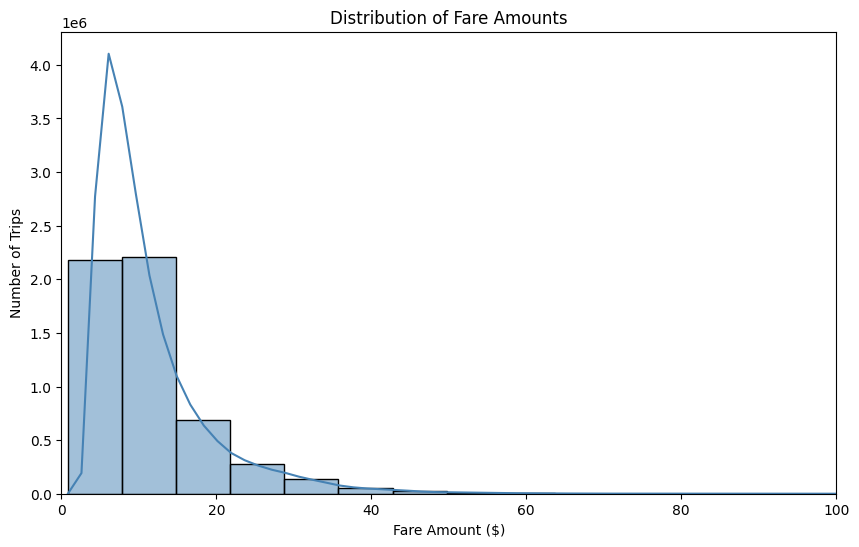

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(taxi_data['fare_amount'], bins=50, kde=True, color='steelblue')
plt.title('Distribution of Fare Amounts')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Number of Trips')
plt.xlim(0, 100)  # focus on typical fares
plt.show()


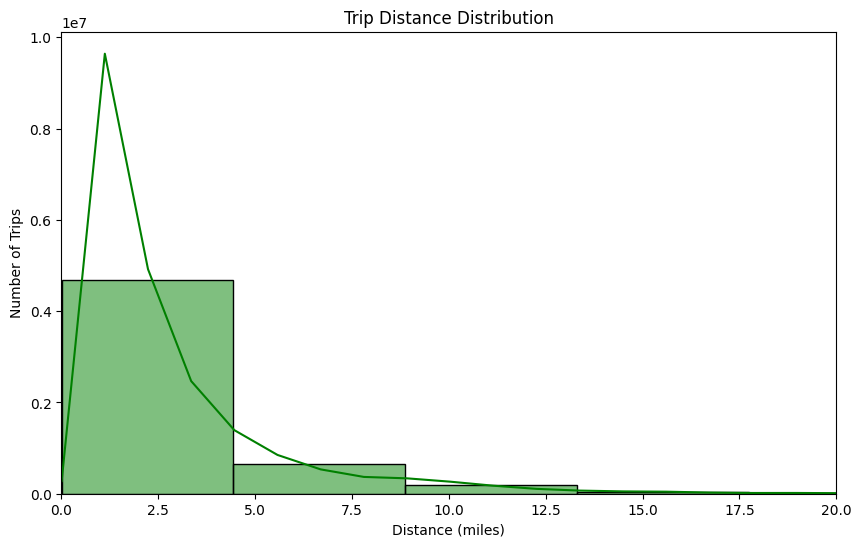

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(taxi_data['trip_distance'], bins=50, kde=True, color='green')
plt.title('Trip Distance Distribution')
plt.xlabel('Distance (miles)')
plt.ylabel('Number of Trips')
plt.xlim(0, 20)  # remove outliers for better view
plt.show()


<ipython-input-39-76d277dfce1d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pickup_hour', data=taxi_data, palette='coolwarm')


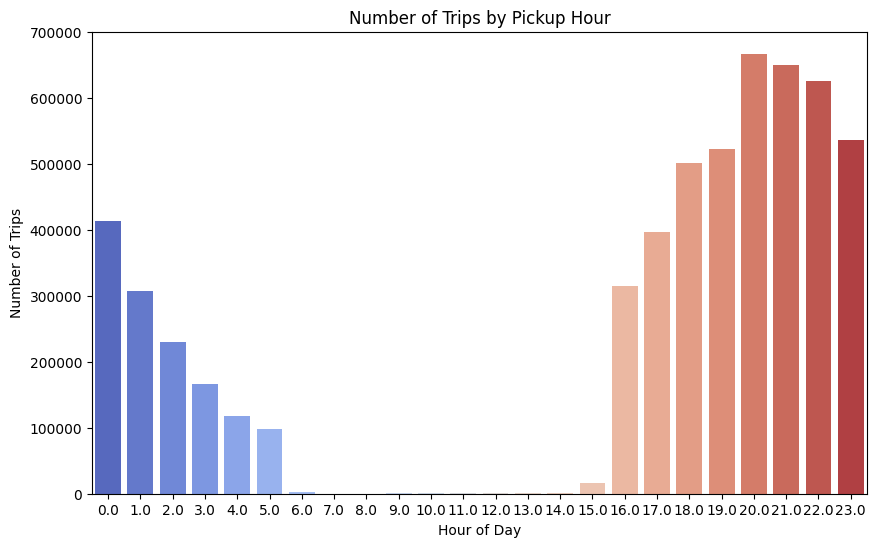

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='pickup_hour', data=taxi_data, palette='coolwarm')
plt.title('Number of Trips by Pickup Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.show()


<ipython-input-40-fc40efe344df>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pickup_day', data=taxi_data, palette='viridis')


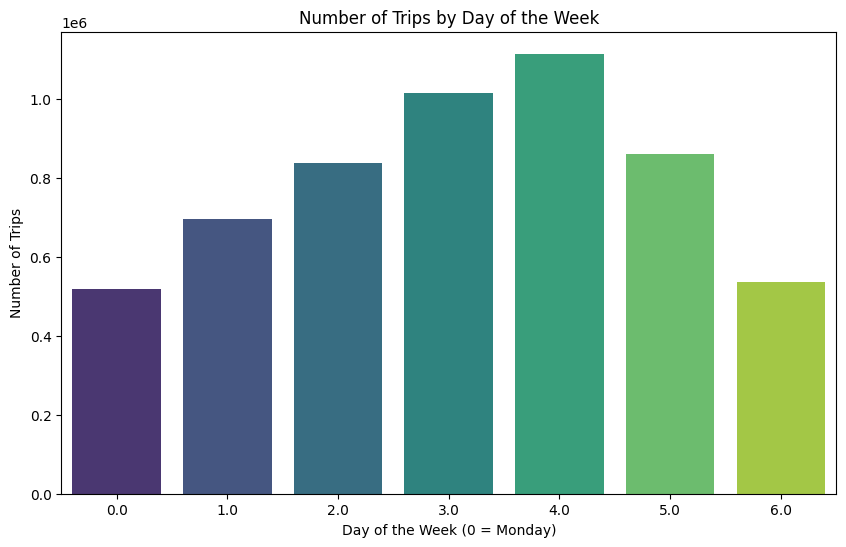

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='pickup_day', data=taxi_data, palette='viridis')
plt.title('Number of Trips by Day of the Week')
plt.xlabel('Day of the Week (0 = Monday)')
plt.ylabel('Number of Trips')
plt.show()


In [ ]:
# Select important columns
features = ['trip_distance', 'pickup_hour', 'pickup_day']
target = 'fare_amount'



In [ ]:
# Drop missing values if any
taxi_data = taxi_data.dropna(subset=features + [target])


In [ ]:
# Split into train and test
X = taxi_data[features]
y = taxi_data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)


In [ ]:
# Set parameters
params = {
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'nthread': -1
}

In [ ]:
# Train XGBoost model
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100
)


In [ ]:
# Predict and evaluate
y_pred = xgb_model.predict(dtest)

# Old sklearn version: calculate RMSE manually
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"XGBoost RMSE: {rmse:.2f}")


XGBoost RMSE: 1.69


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")


MAE: 0.98


In [ ]:
# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")


R²: 0.9515
